# Projet Arbres de décision et Méthodes d'agrégations
-- Par Isaline Hervé - M2 ECAP --

# Importation des packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, SimpleImputer
import scipy.stats as stats

# Importation des données et premiers traitements
## Importation des données

In [2]:
df = pd.read_csv('./data/train.csv', header=0)
df.info()
# 7094 lignes, 25 colonnes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7094 entries, 0 to 7093
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   nom_du_projet                        7094 non-null   object 
 1   resume_du_projet                     6917 non-null   object 
 2   montant_engage                       7094 non-null   float64
 3   numero_ej                            6025 non-null   float64
 4   numero_operateur                     1072 non-null   object 
 5   opérateur                            1072 non-null   object 
 6   demarche                             6962 non-null   object 
 7   nom_region                           6929 non-null   object 
 8   nom_departement                      6929 non-null   object 
 9   code_departement                     6929 non-null   object 
 10  siret_beneficiaire                   6930 non-null   float64
 11  raison_sociale_beneficiaire   

In [3]:
df.head()

,nom_du_projet,resume_du_projet,montant_engage,numero_ej,numero_operateur,opérateur,demarche,nom_region,nom_departement,code_departement,...,siret,activitePrincipale,codePostal,dateCreation,categorieEntreprise,trancheEffectifsUniteLegale,societeMissionUniteLegale,etatAdministratifEtablissement,anneeEffectifsEtablissement,economieSocialeSolidaireUniteLegale
0,"Changement des fenêtres ,des portes et pose de...","Suite aux différents audits, il convient de fi...",20710.00,2.104489e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Normandie,Eure,27,...,2.000561e+13,84.11Z,27160.0,2016-01-01,PME,12,NaN,A,2023.0,N
1,ZAC Bernard Duval,La ZAC Claude Bernard / Alexandre Duval à Renn...,200000.00,2.104469e+09,NaN,NaN,Recyclage foncier,Bretagne,Ille-et-Vilaine,35,...,5.231896e+13,42.99Z,35200.0,2010-05-10,ETI,03,NaN,A,2023.0,N
2,Travaux d'urgence de confortement et d'aménage...,Suites aux intempéries du début du mois de déc...,14157.02,2.104386e+09,NaN,NaN,Appui aux collectivités de montagne soumises à...,Provence-Alpes-Côte d'Azur,Hautes-Alpes,05,...,2.000673e+13,84.11Z,5230.0,2017-01-01,PME,12,NaN,A,2023.0,N
3,Rénovation thermique de l'école de GERBEPAL - ...,La commune de GERBÉPAL souhaite rénover le bât...,202019.00,2.104371e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Grand Est,Vosges,88,...,2.188020e+13,84.11Z,88430.0,1999-12-25,PME,11,NaN,A,2023.0,N
4,Rénovation énergétique du Centre Omnisport de ...,Situé à proximité du quartier de Marbé au nord...,587251.00,2.104409e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Bourgogne-Franche-Comté,Saône-et-Loire,71,...,2.171027e+13,84.11Z,71000.0,1983-03-01,ETI,42,NaN,A,2023.0,N


In [4]:
# Modification des noms de colonnes
df = df.rename(columns={
    "opérateur": "operateur",
    "forme juridique_beneficiaire": "forme_juridique_beneficiaire",
    "activitePrincipale": "activite_principale",
    "codePostal": "code_postal",
    "dateCreation": "date_creation",
    "categorieEntreprise": "categorie_entreprise",
    "trancheEffectifsUniteLegale": "tranche_effectifs_unite_legale",
    "societeMissionUniteLegale": "societe_mission_unite_legale",
    "etatAdministratifEtablissement": "etat_administratif_etablissement",
    "anneeEffectifsEtablissement": "annee_effectifs_etablissement",
    "economieSocialeSolidaireUniteLegale": "economie_sociale_solidaire_unite_legale"
})

# Vérification 
df.head()

,nom_du_projet,resume_du_projet,montant_engage,numero_ej,numero_operateur,operateur,demarche,nom_region,nom_departement,code_departement,...,siret,activite_principale,code_postal,date_creation,categorie_entreprise,tranche_effectifs_unite_legale,societe_mission_unite_legale,etat_administratif_etablissement,annee_effectifs_etablissement,economie_sociale_solidaire_unite_legale
0,"Changement des fenêtres ,des portes et pose de...","Suite aux différents audits, il convient de fi...",20710.00,2.104489e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Normandie,Eure,27,...,2.000561e+13,84.11Z,27160.0,2016-01-01,PME,12,NaN,A,2023.0,N
1,ZAC Bernard Duval,La ZAC Claude Bernard / Alexandre Duval à Renn...,200000.00,2.104469e+09,NaN,NaN,Recyclage foncier,Bretagne,Ille-et-Vilaine,35,...,5.231896e+13,42.99Z,35200.0,2010-05-10,ETI,03,NaN,A,2023.0,N
2,Travaux d'urgence de confortement et d'aménage...,Suites aux intempéries du début du mois de déc...,14157.02,2.104386e+09,NaN,NaN,Appui aux collectivités de montagne soumises à...,Provence-Alpes-Côte d'Azur,Hautes-Alpes,05,...,2.000673e+13,84.11Z,5230.0,2017-01-01,PME,12,NaN,A,2023.0,N
3,Rénovation thermique de l'école de GERBEPAL - ...,La commune de GERBÉPAL souhaite rénover le bât...,202019.00,2.104371e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Grand Est,Vosges,88,...,2.188020e+13,84.11Z,88430.0,1999-12-25,PME,11,NaN,A,2023.0,N
4,Rénovation énergétique du Centre Omnisport de ...,Situé à proximité du quartier de Marbé au nord...,587251.00,2.104409e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Bourgogne-Franche-Comté,Saône-et-Loire,71,...,2.171027e+13,84.11Z,71000.0,1983-03-01,ETI,42,NaN,A,2023.0,N


## Vérification et traitement des doublons

In [5]:
# Vérification des doublons 
dupes = df.duplicated().sum()
print(f"Number of duplicate rows: {dupes}")
# Pas de doublons détectés

Number of duplicate rows: 0


## Vérification et traitement des valeurs manquantes

In [6]:
# Vérification des valeurs manquantes
print(f"Number of missing values per column:\n{df.isnull().sum().sort_values(ascending=False)}")
# Beaucoup de valeurs manquantes, notamment dans societeMissionUniteLegale, operateur et numero_operateur
# Pas de valeurs manquantes dans nom_du_projet et montant_engage

Number of missing values per column:
societe_mission_unite_legale               7082
operateur                                  6022
numero_operateur                           6022
economie_sociale_solidaire_unite_legale    1966
numero_ej                                  1069
annee_effectifs_etablissement               394
etat_administratif_etablissement            237
categorie_entreprise                        218
resume_du_projet                            177
code_postal                                 168
tranche_effectifs_unite_legale              165
date_creation                               165
nom_region                                  165
nom_departement                             165
siret                                       165
code_departement                            165
activite_principale                         165
siret_beneficiaire                          164
raison_sociale_beneficiaire                 138
forme_juridique_beneficiaire                138
dem

In [7]:
# Visualisation des valeurs manquantes en pourcentage
na = df.isna().sum()/df.shape[0]*100 # pourcentage de valeurs manquantes par variable
palettehex = sns.color_palette("Paired").as_hex()
px.bar(na.sort_values(),
         title = "Pourcentage de valeurs manquantes par variable",
         color_discrete_sequence = palettehex[0:1],
         template='ggplot2',
         range_y = [0,100],
         width=800,
         labels={'value':'%', 'index':''},
         color=None
        ).update_traces(showlegend=False).update_xaxes(tickangle=45)
# societeMissionUniteLegale, numero_operateur et operateur ont plus de 70% de valeurs manquantes

In [8]:
# Traitement des valeurs manquantes
NON_RENSEIGNE = "Non_renseigne"

# Colonnes où toute valeur manquante entraîne la suppression de la ligne (car pas de sens à imputer)
DROP_ROW_IF_NA = [
    # Identifiants
    "nom_du_projet",
    "numero_ej",
    "numero_operateur",
    "operateur",
    # Catégories d'entreprise
    "categorie_entreprise",
    "categorie_juridique_unite_legale",
    "tranche_effectifs_unite_legale",
    # Temporel
    "date_creation",
    # Activité
    "activite_principale",
    # Administratif
    "etat_administratif_etablissement",
    "annee_effectifs_etablissement",
    "raison_sociale_beneficiaire",
    "forme_juridique_beneficiaire",
    # Autres
    "resume_du_projet"
]

# Colonnes où les valeurs manquantes doivent être remplacées
REPLACE_NA_COLS = [
    # Géographie à l'échelle communale
    "code_commune",
    "nom_commune",
    # Binaires institutionnelles
    "societe_mission_unite_legale",
    "economie_sociale_solidaire_unite_legale"
]

df = df.copy()

# 1 - Suppression des colonnes avec > 30 % de valeurs manquantes
missing_rate_cols = df.isna().mean()
cols_to_drop = missing_rate_cols[missing_rate_cols > 0.30].index.tolist()

# Affichage des colonnes qui vont être supprimées
print("Colonnes supprimées (>30% de valeurs manquantes) :")
print(cols_to_drop)

# Suppression
df.drop(columns=cols_to_drop, inplace=True)

# 2 - > 5 % de manquants → "Non_renseigne"
# (appliquée après suppression des colonnes > 30 %)
missing_rate_cols = df.isna().mean()
cols_to_fill = missing_rate_cols[
    (missing_rate_cols > 0.05) & (missing_rate_cols <= 0.30)
].index.tolist()

for col in cols_to_fill:
    if col in df.columns and df[col].dtype == "object":
        df[col] = df[col].fillna(NON_RENSEIGNE)

# 3 - Remplacement explicite par "Non_renseigne"
for col in REPLACE_NA_COLS:
    if col in df.columns:
        df[col] = df[col].fillna(NON_RENSEIGNE)

# 4 - Suppression des lignes avec valeurs manquantes
existing_drop_cols = [c for c in DROP_ROW_IF_NA if c in df.columns]
df.dropna(subset=existing_drop_cols, inplace=True)

# Vérification finale
print("\nShape finale :", df.shape)
print("\nValeurs manquantes restantes :")
print(df.isna().sum().sort_values(ascending=False))

Colonnes supprimées (>30% de valeurs manquantes) :
['numero_operateur', 'operateur', 'societe_mission_unite_legale']

Shape finale : (5679, 22)

Valeurs manquantes restantes :
nom_du_projet                              0
resume_du_projet                           0
montant_engage                             0
numero_ej                                  0
demarche                                   0
nom_region                                 0
nom_departement                            0
code_departement                           0
siret_beneficiaire                         0
raison_sociale_beneficiaire                0
forme_juridique_beneficiaire               0
code_commune                               0
nom_commune                                0
siret                                      0
activite_principale                        0
code_postal                                0
date_creation                              0
categorie_entreprise                       0
tranche_effect

In [9]:
df.head()

,nom_du_projet,resume_du_projet,montant_engage,numero_ej,demarche,nom_region,nom_departement,code_departement,siret_beneficiaire,raison_sociale_beneficiaire,...,nom_commune,siret,activite_principale,code_postal,date_creation,categorie_entreprise,tranche_effectifs_unite_legale,etat_administratif_etablissement,annee_effectifs_etablissement,economie_sociale_solidaire_unite_legale
0,"Changement des fenêtres ,des portes et pose de...","Suite aux différents audits, il convient de fi...",20710.00,2.104489e+09,Rénovation énergétique des bâtiments publics l...,Normandie,Eure,27,2.000561e+13,COMMUNE DE MARBOIS,...,Marbois,2.000561e+13,84.11Z,27160.0,2016-01-01,PME,12,A,2023.0,N
1,ZAC Bernard Duval,La ZAC Claude Bernard / Alexandre Duval à Renn...,200000.00,2.104469e+09,Recyclage foncier,Bretagne,Ille-et-Vilaine,35,5.231896e+13,TERRITOIRES PUBLICS,...,Rennes,5.231896e+13,42.99Z,35200.0,2010-05-10,ETI,03,A,2023.0,N
2,Travaux d'urgence de confortement et d'aménage...,Suites aux intempéries du début du mois de déc...,14157.02,2.104386e+09,Appui aux collectivités de montagne soumises à...,Provence-Alpes-Côte d'Azur,Hautes-Alpes,05,2.000673e+13,CC SERRE-PONCON VAL D'AVANCE,...,La Bâtie-Neuve,2.000673e+13,84.11Z,5230.0,2017-01-01,PME,12,A,2023.0,N
3,Rénovation thermique de l'école de GERBEPAL - ...,La commune de GERBÉPAL souhaite rénover le bât...,202019.00,2.104371e+09,Rénovation énergétique des bâtiments publics l...,Grand Est,Vosges,88,2.188020e+13,COMMUNE DE GERBEPAL,...,Gerbépal,2.188020e+13,84.11Z,88430.0,1999-12-25,PME,11,A,2023.0,N
4,Rénovation énergétique du Centre Omnisport de ...,Situé à proximité du quartier de Marbé au nord...,587251.00,2.104409e+09,Rénovation énergétique des bâtiments publics l...,Bourgogne-Franche-Comté,Saône-et-Loire,71,2.171027e+13,COMMUNE DE MACON,...,Mâcon,2.171027e+13,84.11Z,71000.0,1983-03-01,ETI,42,A,2023.0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5679 entries, 0 to 7093
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   nom_du_projet                            5679 non-null   object 
 1   resume_du_projet                         5679 non-null   object 
 2   montant_engage                           5679 non-null   float64
 3   numero_ej                                5679 non-null   float64
 4   demarche                                 5679 non-null   object 
 5   nom_region                               5679 non-null   object 
 6   nom_departement                          5679 non-null   object 
 7   code_departement                         5679 non-null   object 
 8   siret_beneficiaire                       5679 non-null   float64
 9   raison_sociale_beneficiaire              5679 non-null   object 
 10  forme_juridique_beneficiaire             5679 non-nul

In [ ]:
# Conversion des types de données
df = df.copy()

# 1 - Quantitative continue
quant_cols = ["montant_engage"]
for col in quant_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 2 - Année (numérique)
year_cols = ["annee_effectifs_etablissement"]
for col in year_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 3 - Identifiants / codes (string)
id_cols = [
    "numero_ej",
    "siret",
    "siret_beneficiaire",
    "code_postal",
    "code_departement",
    "code_commune"
]
for col in id_cols:
    if col in df.columns:
        df[col] = df[col].astype("string")

# 4 - Catégorielles fixes (peu de modalities / codées)
cat_cols = [
    "categorie_entreprise",
    "tranche_effectifs_unite_legale",
    "economie_sociale_solidaire_unite_legale",
    "etat_administratif_etablissement",
    "demarche",
    "nom_region",
    "nom_departement"
]
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# 5 - Texte / labels libres
text_cols = [
    "nom_du_projet",
    "resume_du_projet",
    "categorie_juridique_unite_legale",
    "societe_mission_unite_legale",
    "raison_sociale_beneficiaire",
    "activite_principale",
    "forme_juridique_beneficiaire",
    "nom_commune"
]
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype("string")

# 6 - Dates
date_cols = ["date_creation"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# 7 - Vérification finale
print("Types de colonnes après conversion :")
print(df.dtypes)


Types de colonnes après conversion :
nom_du_projet                              string[python]
resume_du_projet                           string[python]
montant_engage                                    float64
numero_ej                                  string[python]
demarche                                         category
nom_region                                       category
nom_departement                                  category
code_departement                           string[python]
siret_beneficiaire                         string[python]
raison_sociale_beneficiaire                string[python]
forme_juridique_beneficiaire               string[python]
code_commune                               string[python]
nom_commune                                string[python]
siret                                      string[python]
activite_principale                        string[python]
code_postal                                string[python]
date_creation                      

## Création de nouvelles variables


# Statistiques descriptives
## Statistiques descriptives univariées

In [ ]:
# Colonnes numériques continues
num_cols = ["montant_engage", "annee_effectifs_etablissement"]
print("\nStatistiques descriptives pour les variables numériques continues :")
display(df[num_cols].describe())
# anne_effectifs_etablissement contient uniquement 2023 -> à supprimer


Statistiques descriptives pour les variables numériques continues :


,montant_engage,annee_effectifs_etablissement
count,5.679000e+03,5679.0
mean,1.759721e+05,2023.0
std,3.290579e+05,0.0
min,2.875000e+02,2023.0
25%,1.634060e+04,2023.0
50%,6.000000e+04,2023.0
75%,2.000000e+05,2023.0
max,6.823074e+06,2023.0


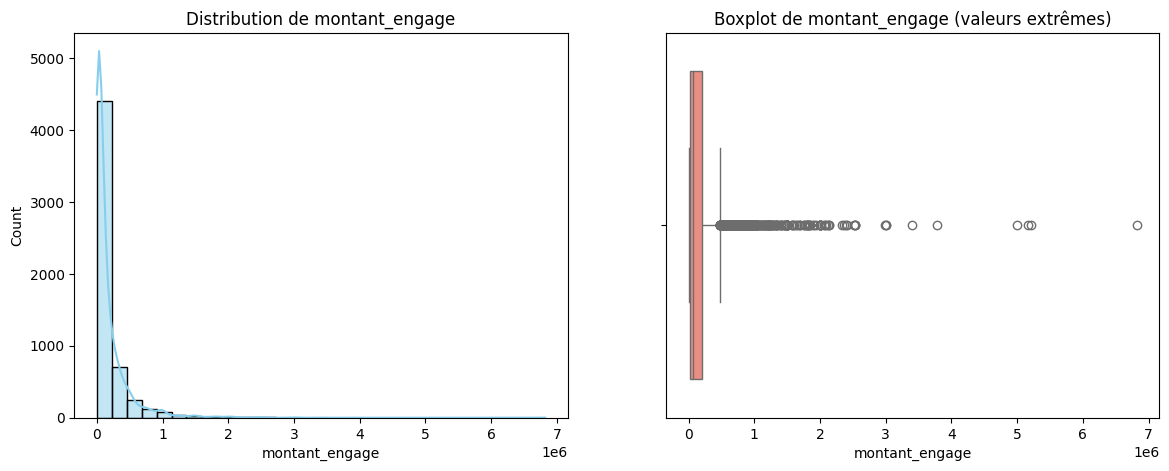

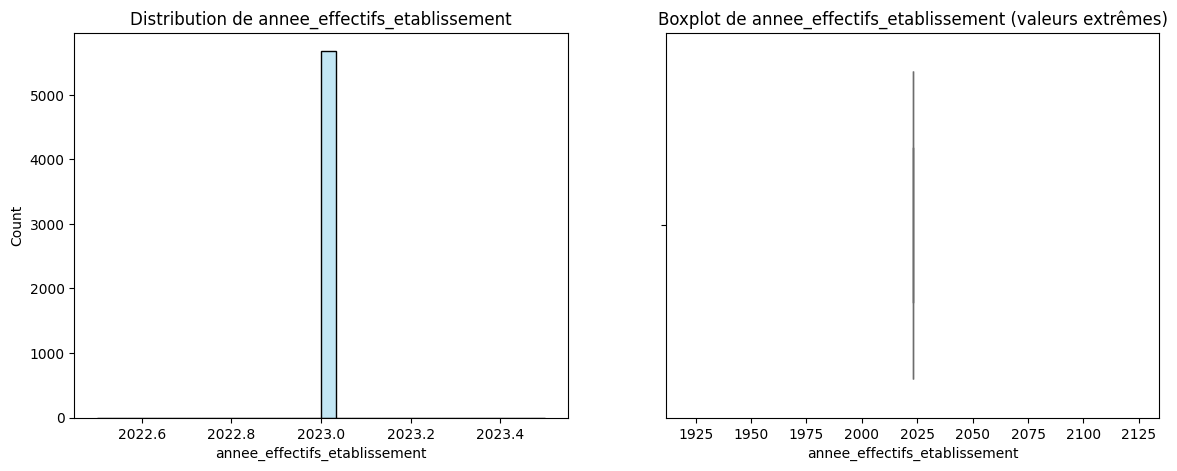

In [13]:
# Distribution et valeurs extrêmes
# Histogrammes + Boxplots pour les numériques
for col in num_cols:
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    
    # Histogramme
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution de {col}")
    
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="salmon")
    axes[1].set_title(f"Boxplot de {col} (valeurs extrêmes)")
    
    plt.show()

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\297793016.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




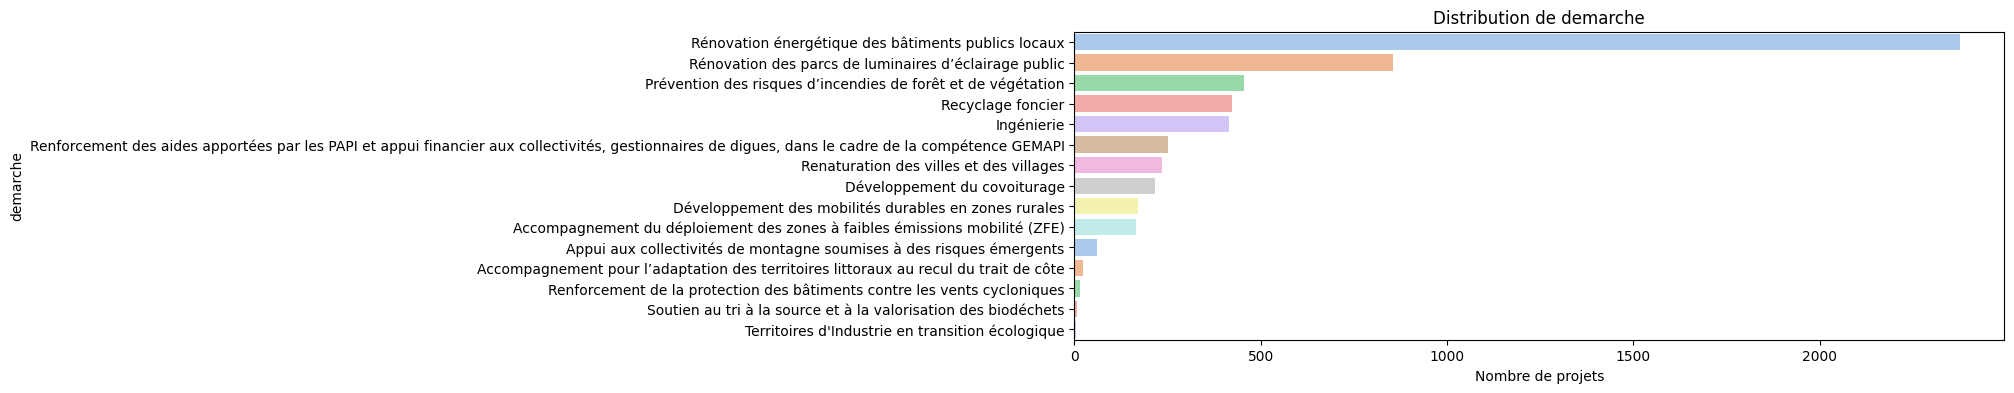


Valeurs uniques et pourcentages pour demarche :
demarche
Rénovation énergétique des bâtiments publics locaux                                                                                                   41.86
Rénovation des parcs de luminaires d’éclairage public                                                                                                 15.07
Prévention des risques d’incendies de forêt et de végétation                                                                                           8.01
Recyclage foncier                                                                                                                                      7.45
Ingénierie                                                                                                                                             7.29
Renforcement des aides apportées par les PAPI et appui financier aux collectivités, gestionnaires de digues, dans le cadre de la compétence GEMAPI     4.42
Renatu

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\297793016.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




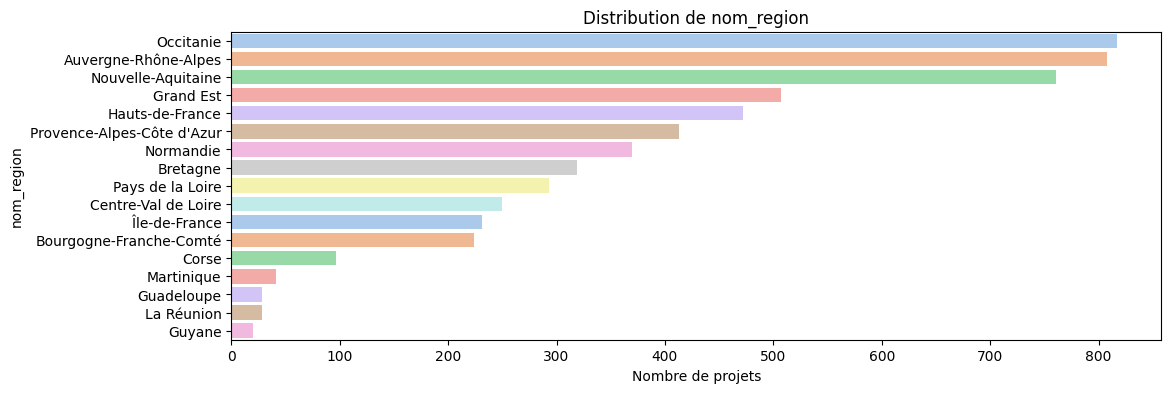


Valeurs uniques et pourcentages pour nom_region :
nom_region
Occitanie                     14.39
Auvergne-Rhône-Alpes          14.23
Nouvelle-Aquitaine            13.40
Grand Est                      8.93
Hauts-de-France                8.31
Provence-Alpes-Côte d'Azur     7.27
Normandie                      6.52
Bretagne                       5.62
Pays de la Loire               5.16
Centre-Val de Loire            4.40
Île-de-France                  4.07
Bourgogne-Franche-Comté        3.94
Corse                          1.71
Martinique                     0.72
Guadeloupe                     0.49
La Réunion                     0.49
Guyane                         0.35
Name: proportion, dtype: float64


C:\Users\isali\AppData\Local\Temp\ipykernel_50804\297793016.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




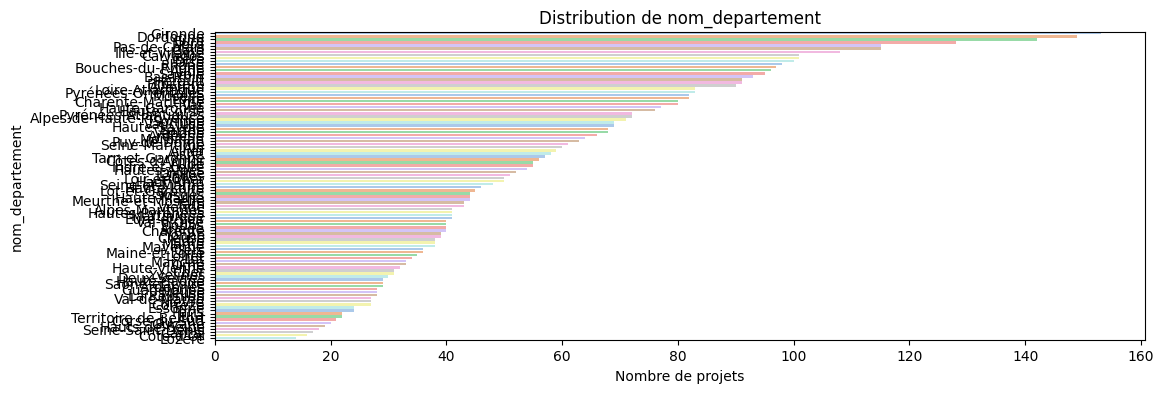


Valeurs uniques et pourcentages pour nom_departement :
nom_departement
Gironde              2.69
Dordogne             2.62
Eure                 2.50
Nord                 2.25
Pas-de-Calais        2.03
                     ... 
Hauts-de-Seine       0.33
Seine-Saint-Denis    0.32
Cantal               0.30
Côte-d'Or            0.28
Lozère               0.25
Name: proportion, Length: 100, dtype: float64


C:\Users\isali\AppData\Local\Temp\ipykernel_50804\297793016.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




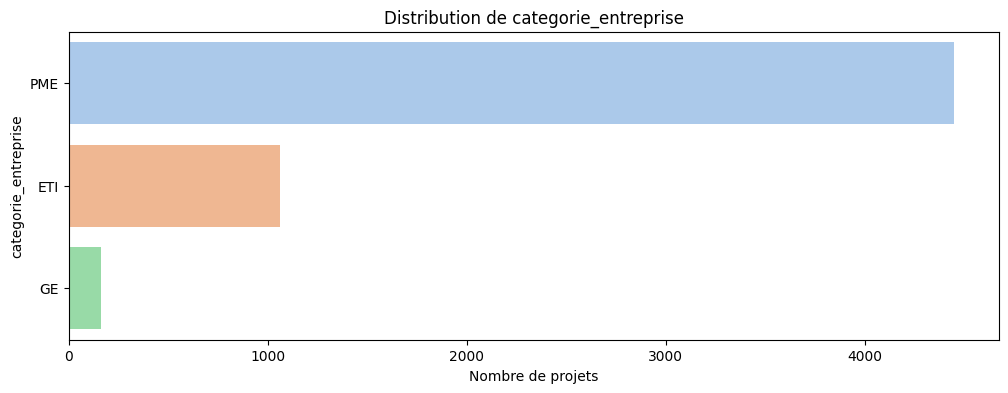


Valeurs uniques et pourcentages pour categorie_entreprise :
categorie_entreprise
PME    78.38
ETI    18.75
GE      2.87
Name: proportion, dtype: float64


C:\Users\isali\AppData\Local\Temp\ipykernel_50804\297793016.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




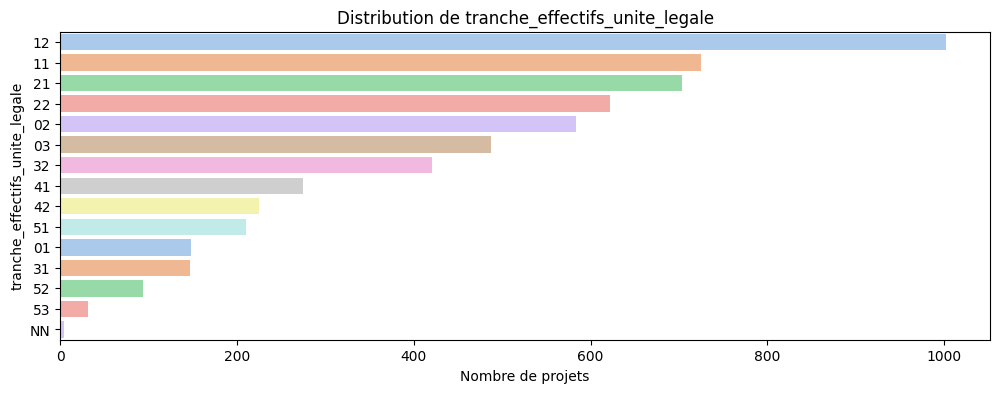


Valeurs uniques et pourcentages pour tranche_effectifs_unite_legale :
tranche_effectifs_unite_legale
12    17.64
11    12.77
21    12.40
22    10.95
02    10.28
03     8.58
32     7.41
41     4.84
42     3.96
51     3.70
01     2.61
31     2.59
52     1.66
53     0.55
NN     0.07
Name: proportion, dtype: float64


C:\Users\isali\AppData\Local\Temp\ipykernel_50804\297793016.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




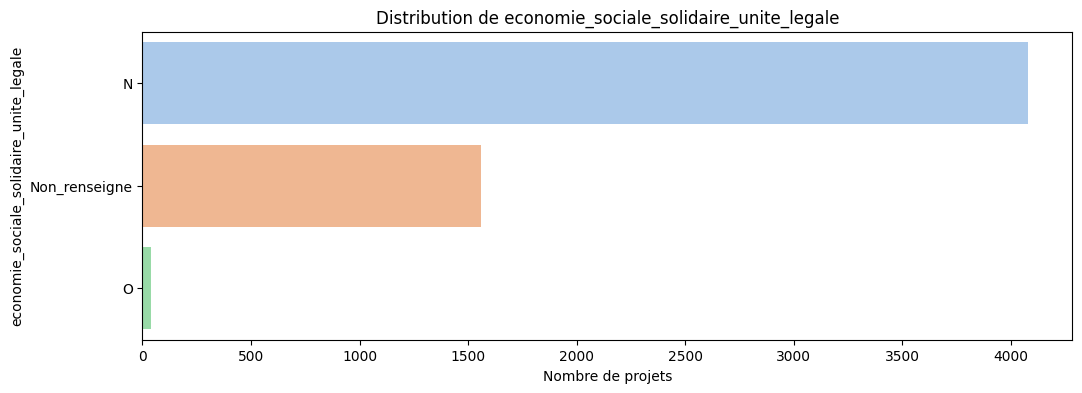

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\297793016.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.





Valeurs uniques et pourcentages pour economie_sociale_solidaire_unite_legale :
economie_sociale_solidaire_unite_legale
N                71.83
Non_renseigne    27.45
O                 0.72
Name: proportion, dtype: float64


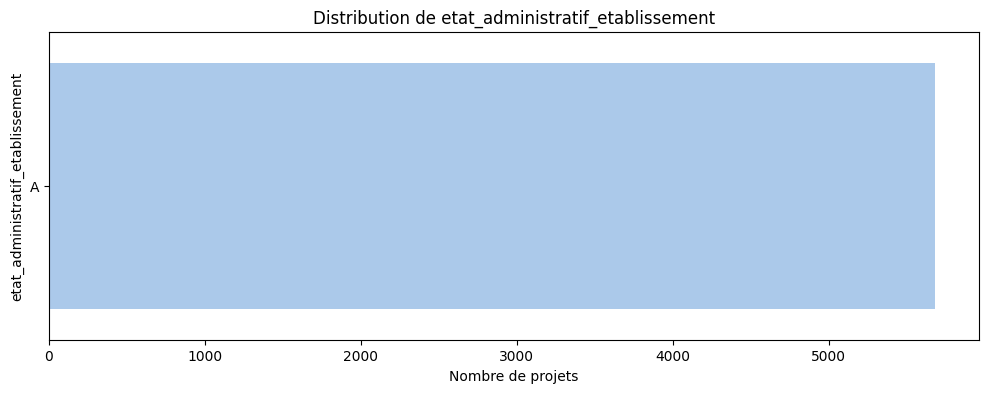


Valeurs uniques et pourcentages pour etat_administratif_etablissement :
etat_administratif_etablissement
A    100.0
Name: proportion, dtype: float64


In [ ]:
# Colonnes catégorielles
cat_cols = [
    "demarche", "nom_region", "nom_departement", "categorie_entreprise",
    "tranche_effectifs_unite_legale",
    "economie_sociale_solidaire_unite_legale",
    "etat_administratif_etablissement"
]

for col in cat_cols:
    plt.figure(figsize=(12,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette="pastel")
    plt.title(f"Distribution de {col}")
    plt.xlabel("Nombre de projets")
    plt.ylabel(col)
    plt.show()

# Vérification déséquilibre
    print(f"\nValeurs uniques et pourcentages pour {col} :")
    print(round(df[col].value_counts(normalize=True)*100,2))

# etat_administratif_etablissement contient uniquement "A" -> à supprimer

## Statistiques descriptives bivariées

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\2553008346.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




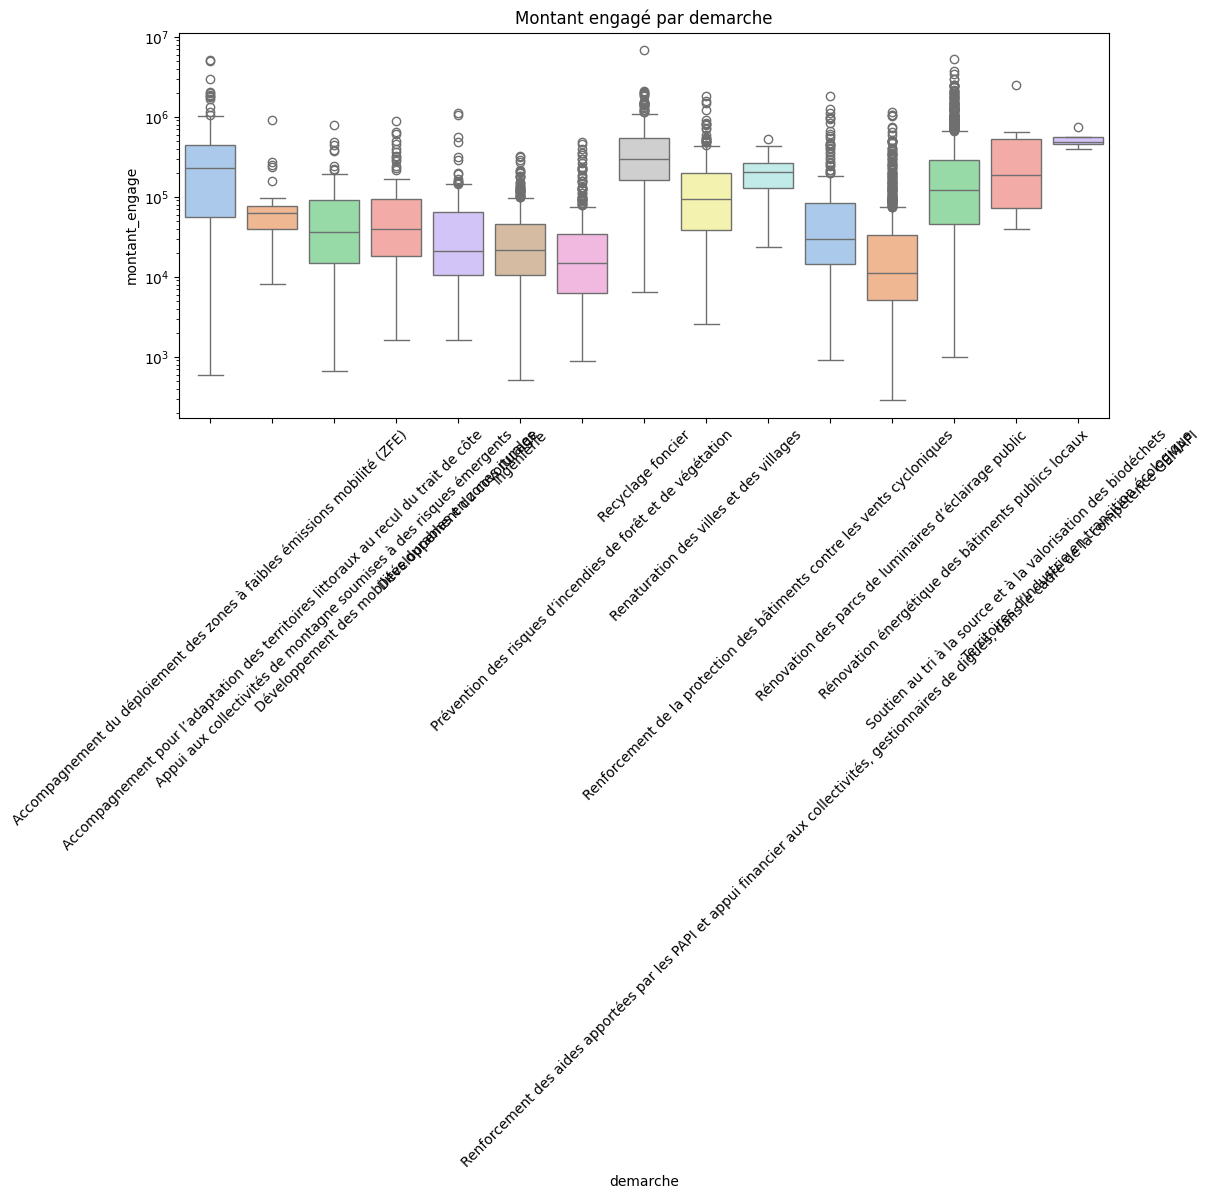

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\2553008346.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




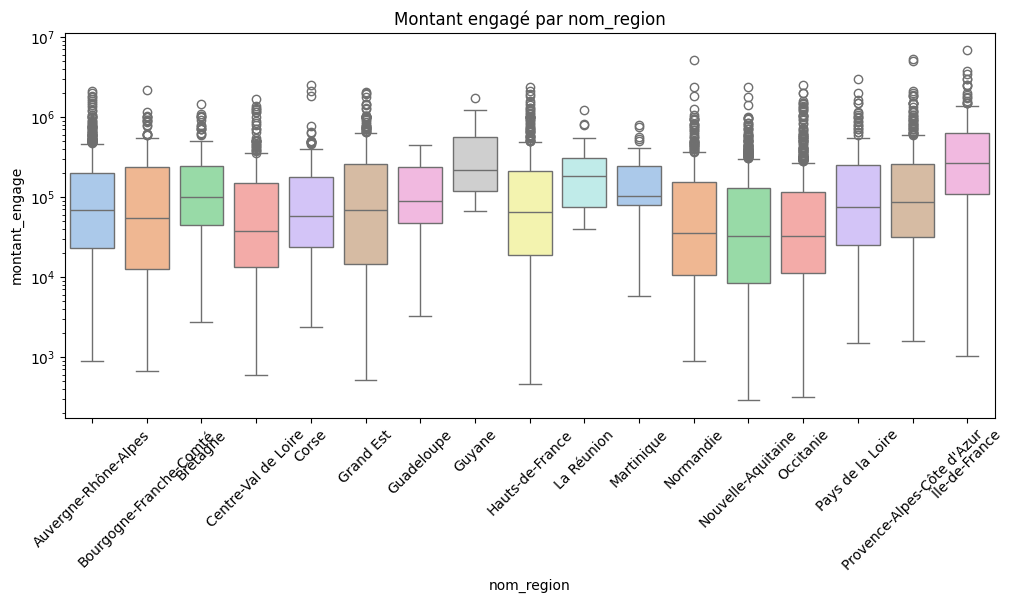

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\2553008346.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




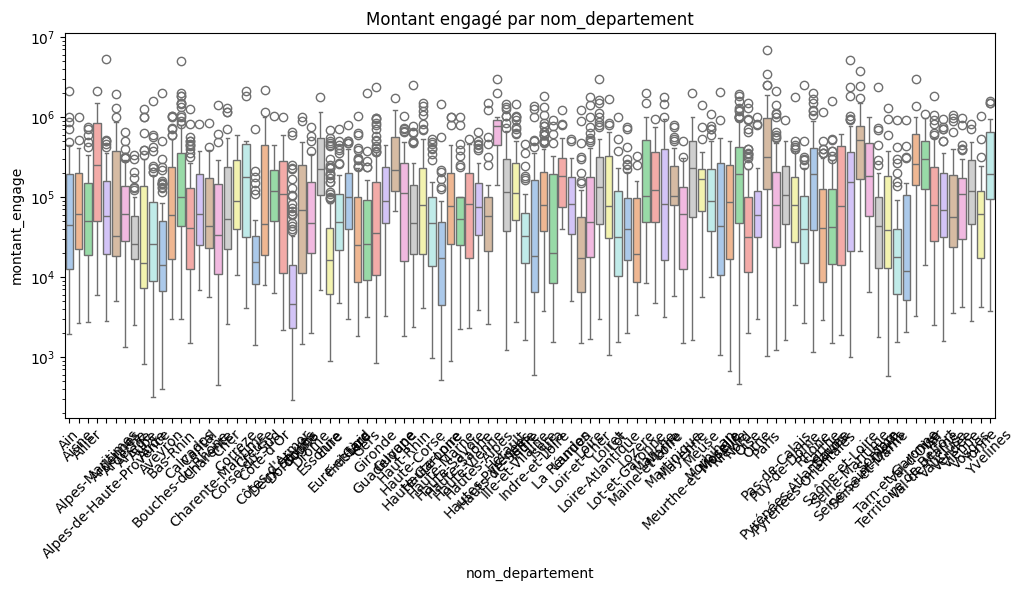

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\2553008346.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




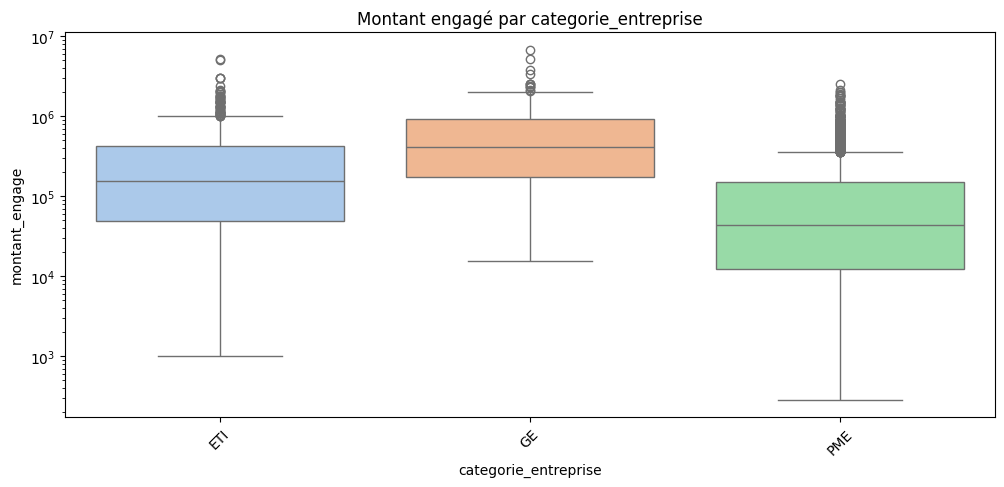

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\2553008346.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




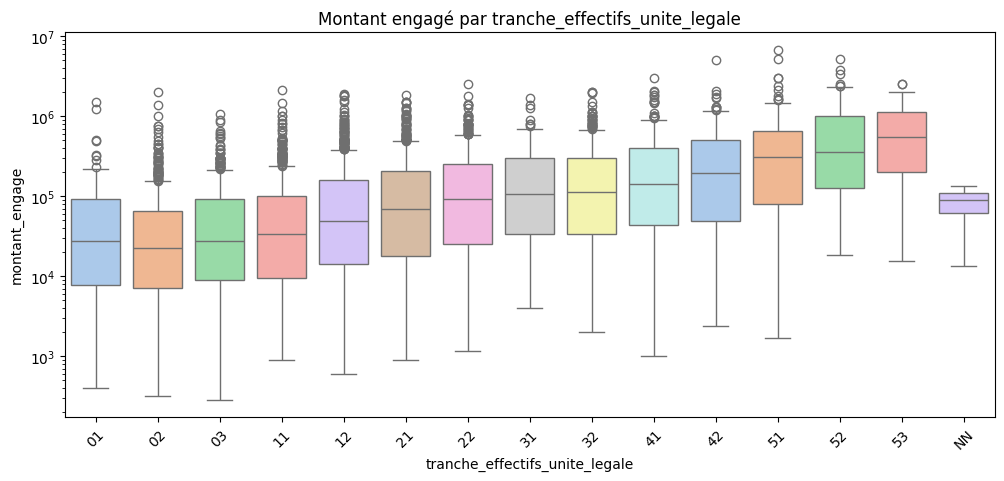

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\2553008346.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




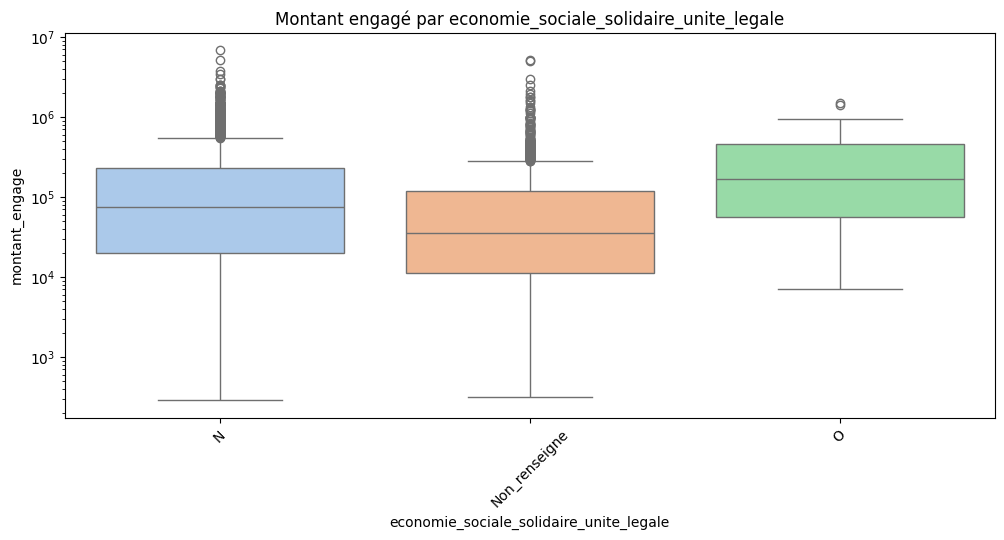

C:\Users\isali\AppData\Local\Temp\ipykernel_50804\2553008346.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




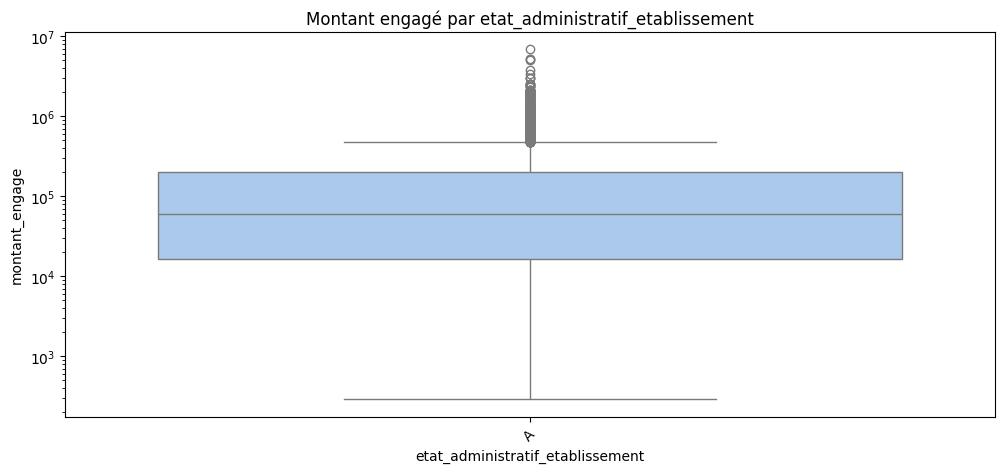

In [17]:
# Corrélation entre variables explicatives
# Corrélation entre variables explicatives catégorielles et variable cible
# Boxplots par catégorie
for col in cat_cols:
    plt.figure(figsize=(12,5))
    sns.boxplot(x=col, y="montant_engage", data=df, palette="pastel")
    plt.yscale("log")  # si variable cible fortement skewée
    plt.title(f"Montant engagé par {col}")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Corrélation entre variables explicatives et variable cible

# Encodage des variables catégorielles

# Modélisation